In [1]:
from pathlib import Path

In [2]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from scipy import signal
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
# グラフのスタイル、サイズ、フォントサイズを指定
sns.set()
japanize_matplotlib.japanize()
plt.rcParams['figure.figsize'] = [12, 9]
plt.rcParams['font.size'] = 14

In [5]:
def check_adf(seqs: np.ndarray) -> bool:
    """ ADF検定を行い、定常性を持つか否かを返す. """
    ctt = adfuller(seqs, regression='ctt')  # トレンド(2次)、定数あり
    ct = adfuller(seqs, regression='ct')    # トレンド(1次)、定数あり
    c = adfuller(seqs, regression='c')      # トレンドなし、定数あり
    nc = adfuller(seqs, regression='n')     # トレンド、定数なし
    # print(f'ctt p-value:\n{ctt[1]}')
    # print(f'ct p-value:\n{ct[1]}')
    # print(f'c p-value:\n{c[1]}')
    # print(f'nc p-value:\n{nc[1]}')
    
    result = adfuller(seqs)
    print(f'ADF Statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical values:')
    for i, j in result[4].items():
        print('\t', i, j)
    
    return ctt[1] <= 0.05 and ct[1] <= 0.05 and c[1] <= 0.05 and nc[1] <= 0.05

In [6]:
def plot_correlogram(seqs: np.ndarray, lags=1) -> None:
    """ コレログラム(自己相関と偏自己相関)をプロットする. """
    acf = plot_acf(seqs, lags=20)    # 自己相関
    pacf = plot_pacf(seqs, lags=20)  # 偏自己相関

### データの読み込み

In [7]:
DATA_DIR = Path().cwd().parent.joinpath('data')

In [8]:
# 対数変換して軸名も変更
df = pd.read_csv(DATA_DIR.joinpath('train_data.csv'), index_col='id', parse_dates=True)
df = np.log1p(df).rename_axis(index='date', columns='vegetable')
df.head()

vegetable,えのきだけ_中国,えのきだけ_九州,えのきだけ_北海道,えのきだけ_北陸,えのきだけ_四国,えのきだけ_東北,えのきだけ_東海,えのきだけ_近畿,えのきだけ_関東,かぶ_北海道,...,レタス_関東,生しいたけ_中国,生しいたけ_九州,生しいたけ_北海道,生しいたけ_北陸,生しいたけ_四国,生しいたけ_東北,生しいたけ_東海,生しいたけ_近畿,生しいたけ_関東
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,5.752573,5.710427,5.720312,5.616771,5.590987,5.365976,5.631212,5.655992,5.634790,4.828314,...,5.605802,7.002156,6.955593,6.603944,7.116394,6.929517,6.896694,7.021084,7.015712,7.020191
2016-02-01,5.726848,5.758902,5.736572,5.666427,5.683580,5.631212,5.659482,5.690359,5.676754,5.062595,...,5.743003,6.985642,6.863803,6.621406,7.124478,6.945051,6.872128,7.038784,7.028201,7.018402
2016-03-01,5.505332,5.384495,5.762051,5.393628,5.429346,5.105945,5.351858,5.365976,5.323010,5.225747,...,5.631212,6.853299,6.606650,6.591674,7.092574,6.787845,6.848005,6.897705,6.843750,6.951772
2016-04-01,5.429346,5.209486,5.720312,5.278115,5.313206,5.036953,5.327876,5.318120,5.247024,5.247024,...,5.347108,6.775366,6.620073,6.599870,6.922644,6.719013,6.788972,6.829794,6.783325,6.890609
2016-05-01,5.451038,5.313206,5.726848,5.332719,5.375278,5.141664,5.402677,5.398163,5.332719,5.017280,...,5.111988,6.787845,6.711740,6.566672,6.962243,6.794587,6.766192,6.849066,6.853299,6.898715


商品別で「えのきだけ」のみを見た結果  
北海道は独自の価格で安定しており、関東は他地域と連動はしているものの振れ幅が大きい

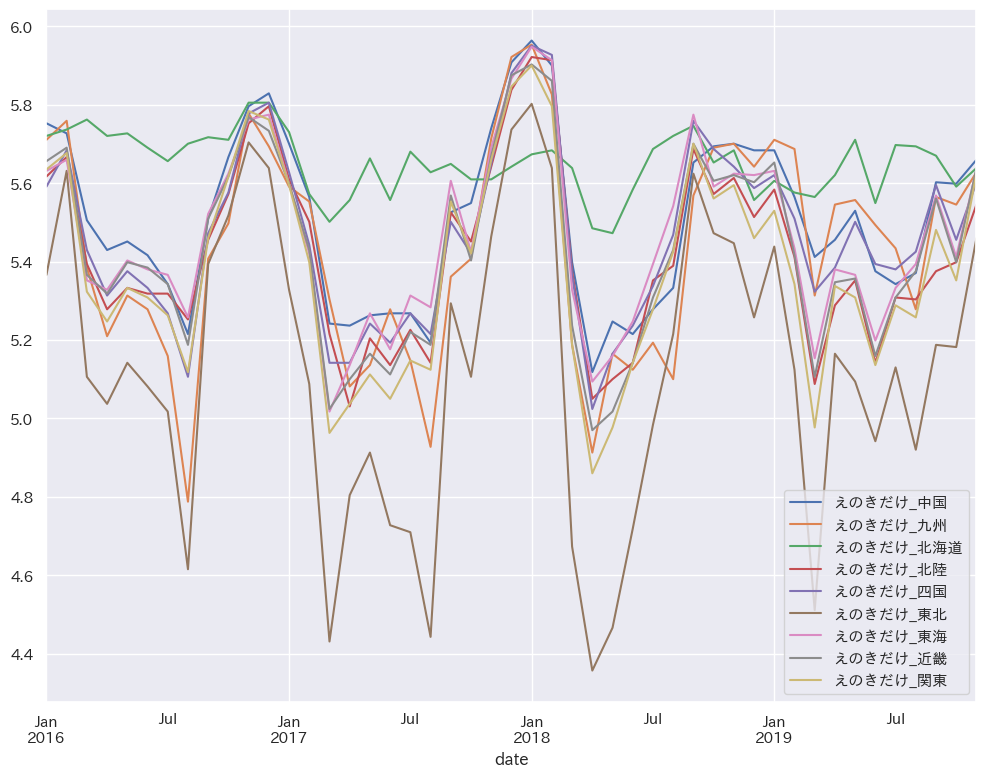

In [9]:
# えのきだけ全体を見てみる
_df = df.filter(like='えのきだけ')
for col in _df.columns:
    df[col].plot()
plt.legend()
plt.show()

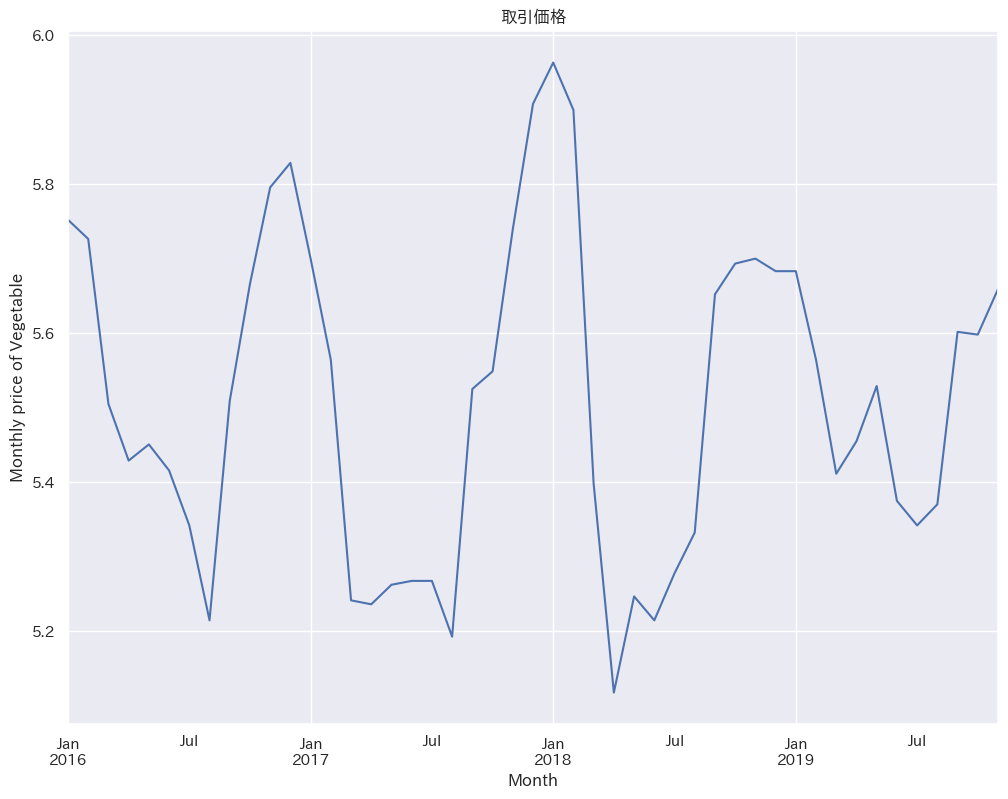

In [10]:
# えのきだけのうち、中国地方のみを確認
_df = df['えのきだけ_中国']
_df.plot()
plt.title('取引価格')
plt.xlabel('Month')
plt.ylabel('Monthly price of Vegetable')
plt.show()

### 変動成分の確認

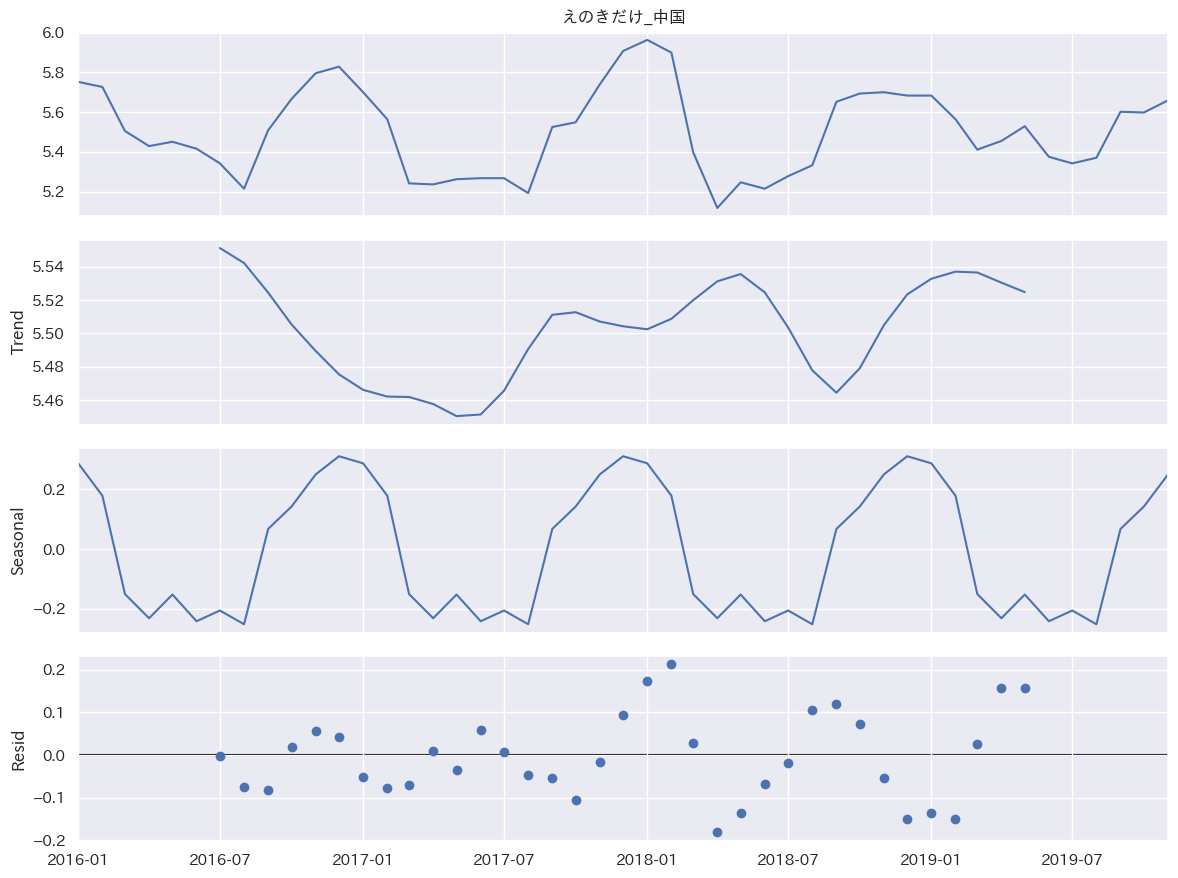

In [52]:
# 加法モデルを仮定し、移動平均法を利用して分解
result = seasonal_decompose(_df, model='additive', period=12)
result.plot()
plt.show()

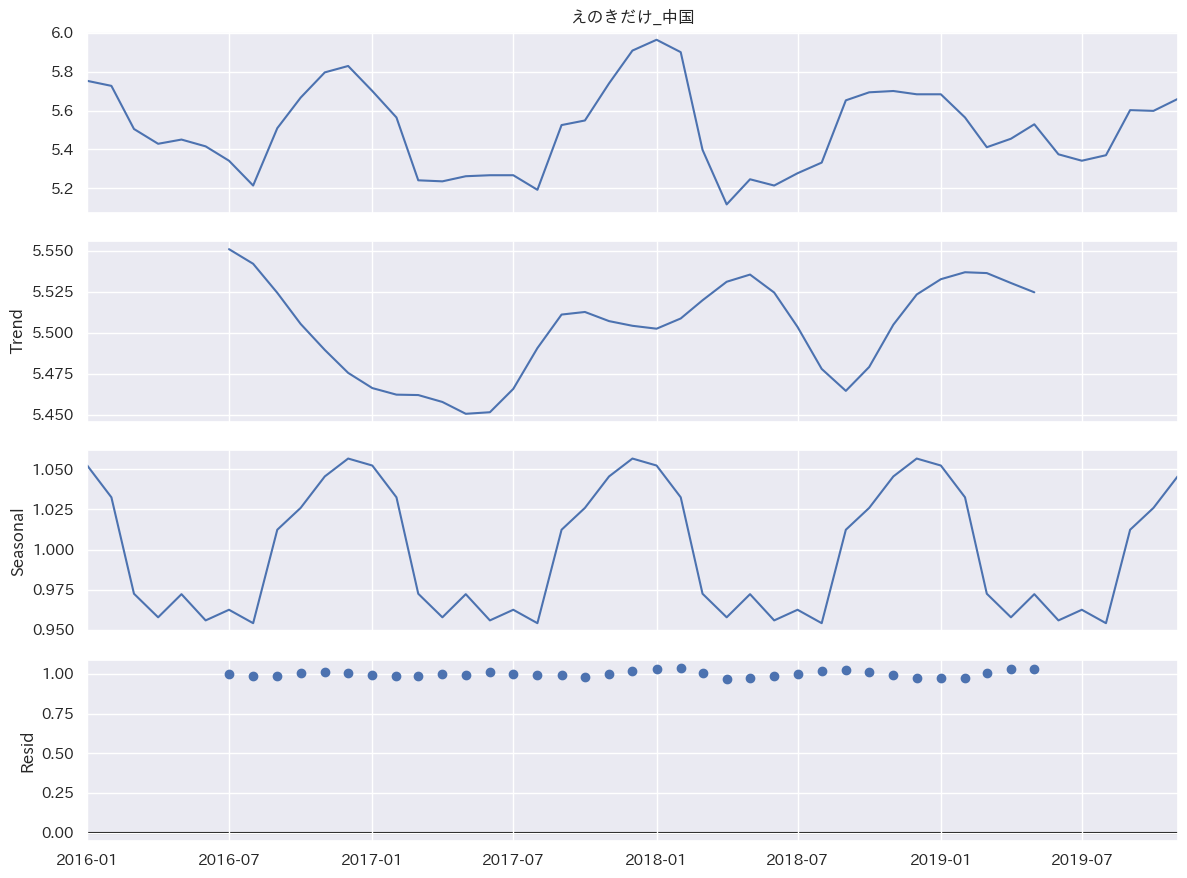

In [53]:
# 乗法モデルを仮定し、移動平均法を利用して分解
result = seasonal_decompose(_df, model='multiplicative', period=12)
result.plot()
plt.show()

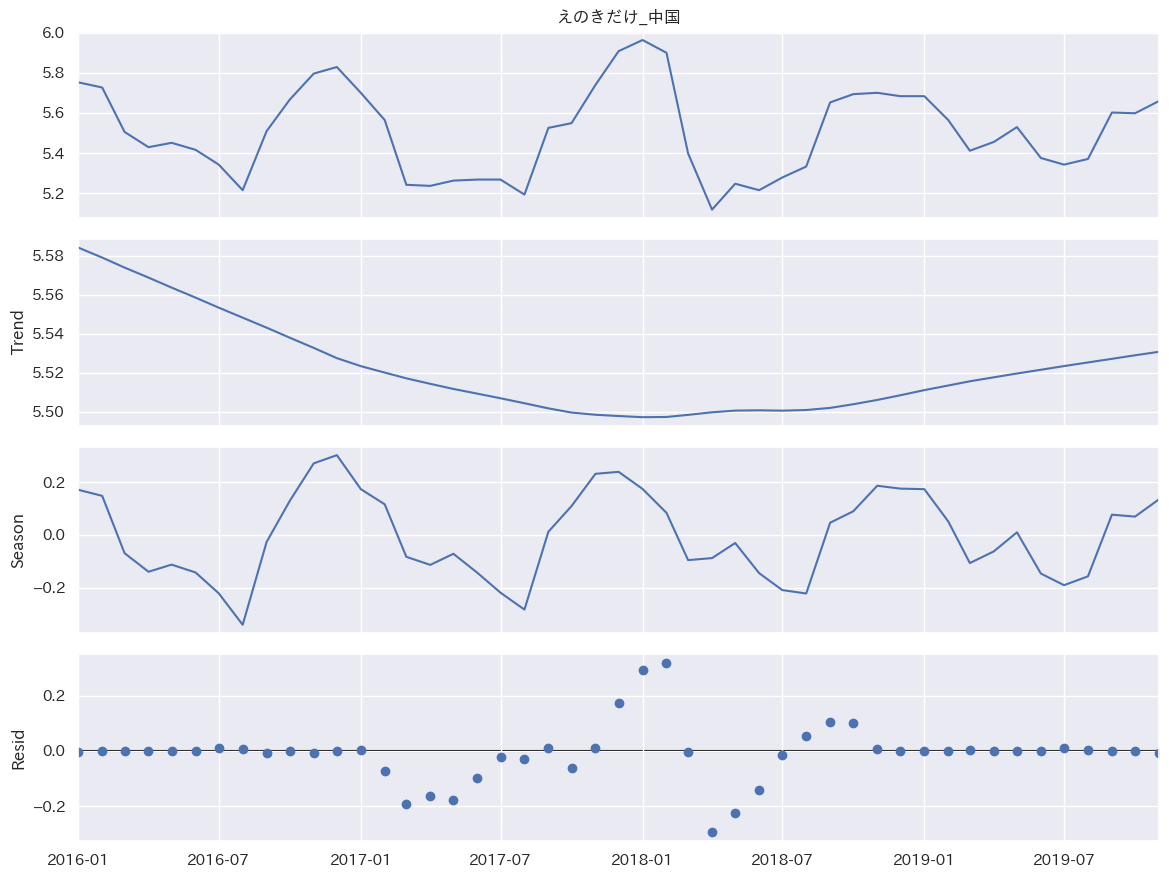

In [54]:
# LOESS平滑化を利用した分解(STL分解)
# 季節成分の振幅の大きさの変化も捉えられ、外れ値に強い特徴があるためこれが無難
stl = STL(_df, period=12, robust=True).fit()
stl.plot()
plt.show()

### 定常性を確認
ADF検定を行い、定常になるまで差分系列を得ることを繰り返す。

他に定常な系列を得るための手法としては以下の二つ。
- トレンド除去
- Box-Cox変換または対数変換

In [60]:
# 定常性の確認
check_adf(_df)

ADF Statistics: -2.4605296369412097
p-value: 0.12537555740368744
Critical values:
	 1% -3.6209175221605827
	 5% -2.9435394610388332
	 10% -2.6104002410518627


False

In [61]:
# 1次階差をとり、定常過程に変換する
_df_diff = _df.diff(1).dropna()
check_adf(_df_diff)

ADF Statistics: -5.939992381248842
p-value: 2.2729212890704794e-07
Critical values:
	 1% -3.6209175221605827
	 5% -2.9435394610388332
	 10% -2.6104002410518627


True

### コレログラムを見る(自己相関と偏自己相関のプロット)

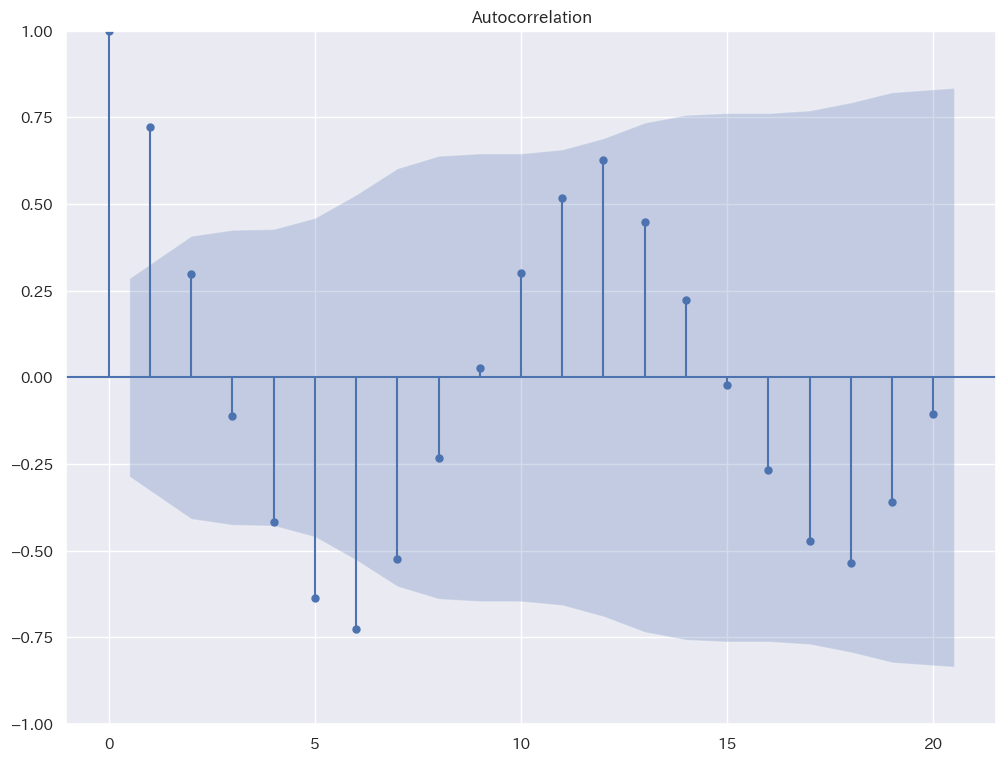

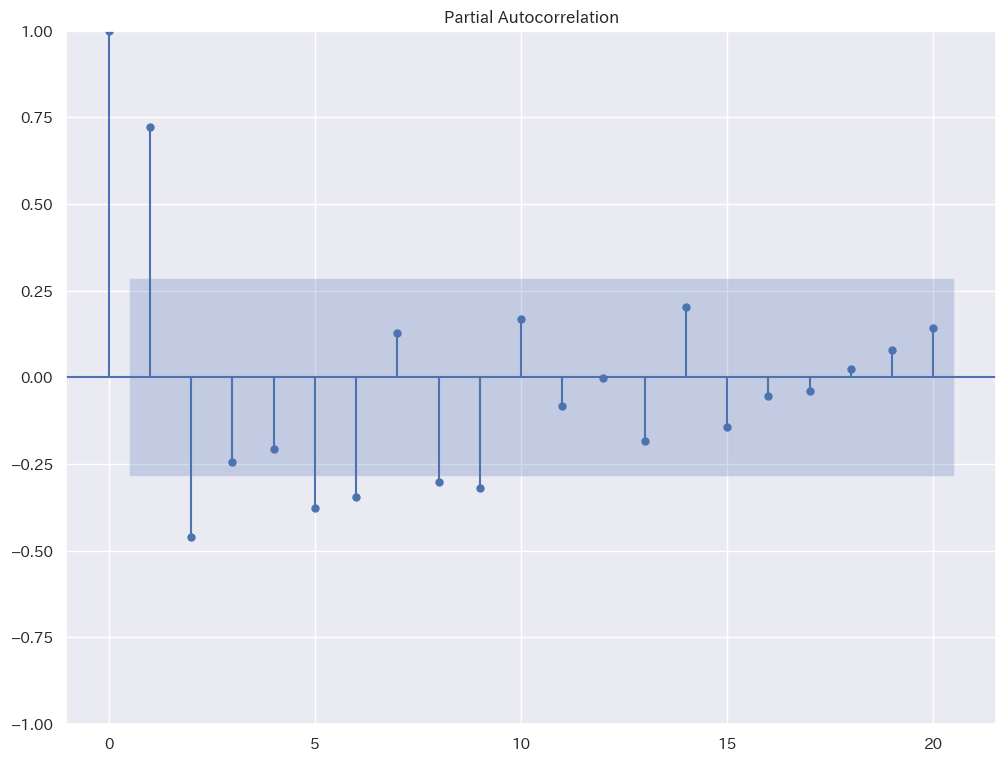

In [68]:
# 原系列
plot_correlogram(_df, lags=20)

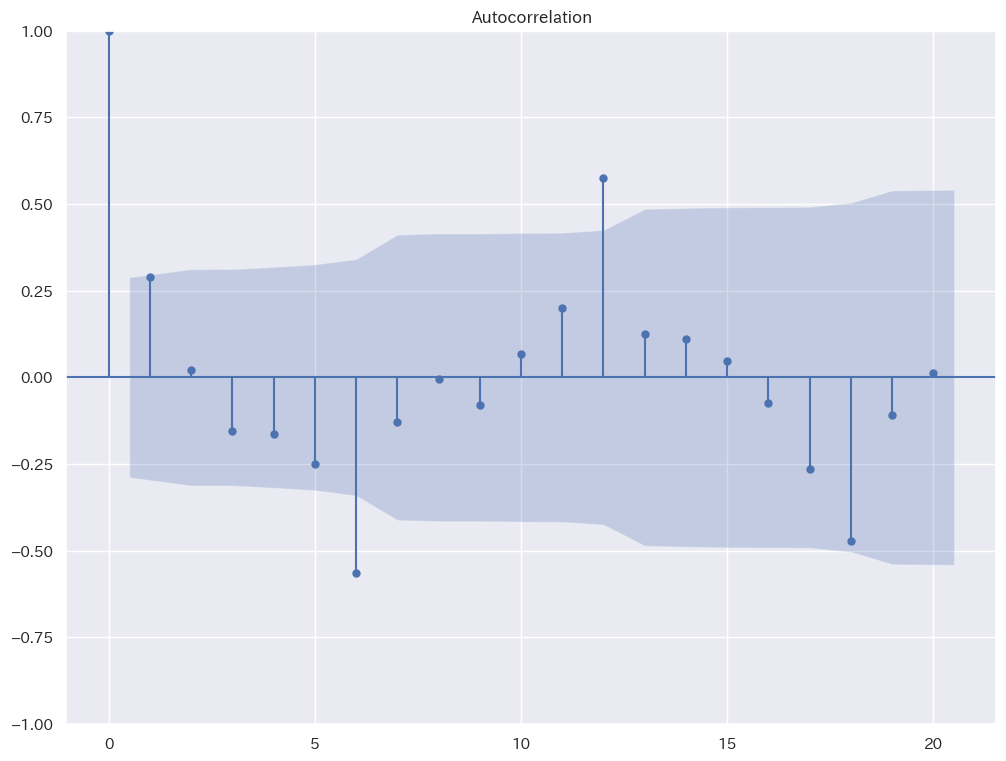

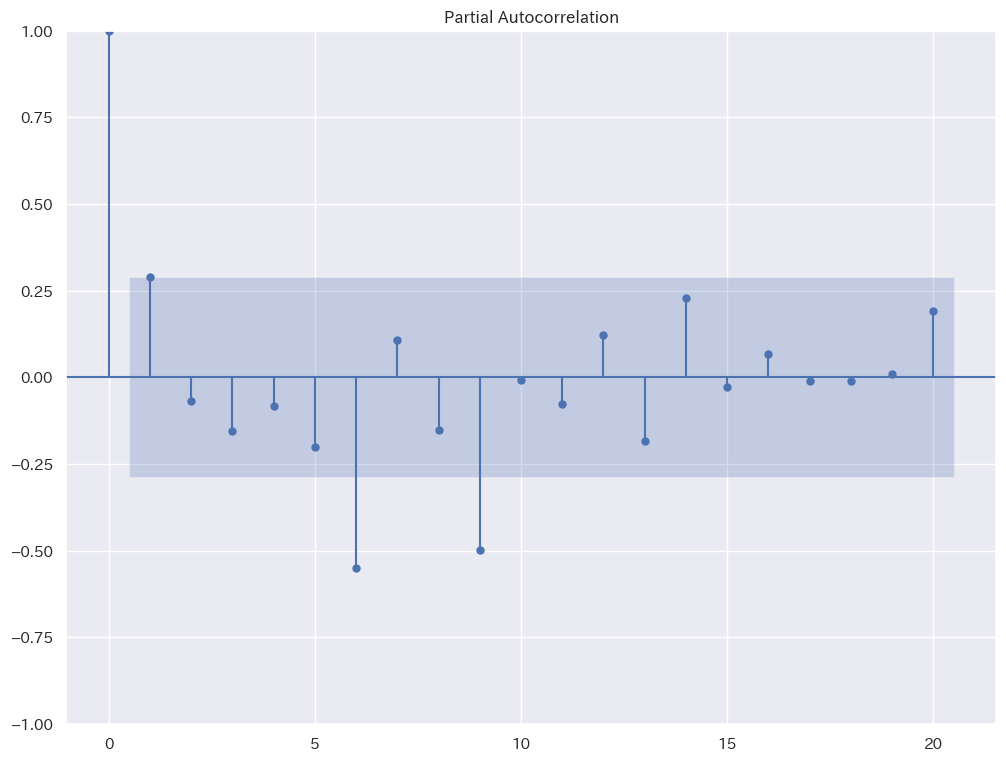

In [69]:
# 1次差分系列
# 自己相関で6, 12が跳ねており、偏自己相関では6のみ跳ねていることから6ヵ月周期があることがわかる
plot_correlogram(_df_diff, lags=20)

### ARモデル

In [36]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# 1次階差系列が定常過程であることを確認できたため、ARモデルを構築
sel = ar_select_order(_df_diff, 13, 'aic')
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               えのきだけ_中国   No. Observations:                   46
Model:                    AutoReg(13)   Log Likelihood                  37.756
Method:               Conditional MLE   S.D. of innovations              0.077
Date:                Thu, 17 Aug 2023   AIC                            -45.511
Time:                        15:27:18   BIC                            -23.064
Sample:                    03-01-2017   HQIC                           -37.958
                         - 11-01-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0027      0.014      0.202      0.840      -0.024       0.029
えのきだけ_中国.L1     -0.0204      0.156     -0.131      0.896      -0.325       0.285
えのきだけ_中国.L2     -0.2351      0.150     -1.57

/home/gemmoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/gemmoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


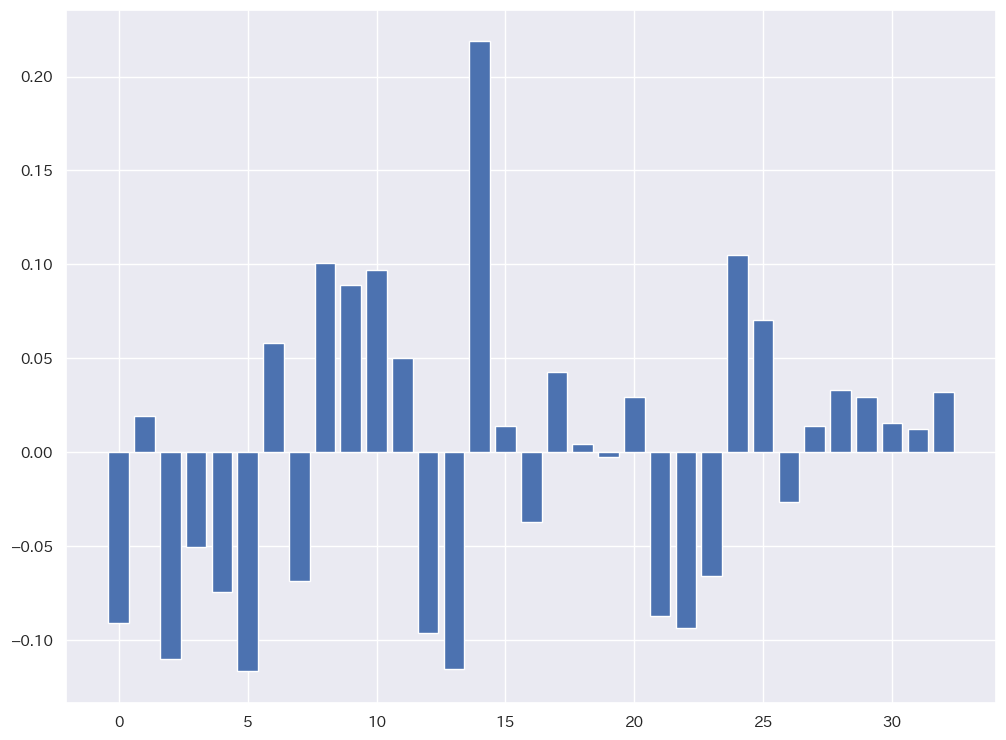

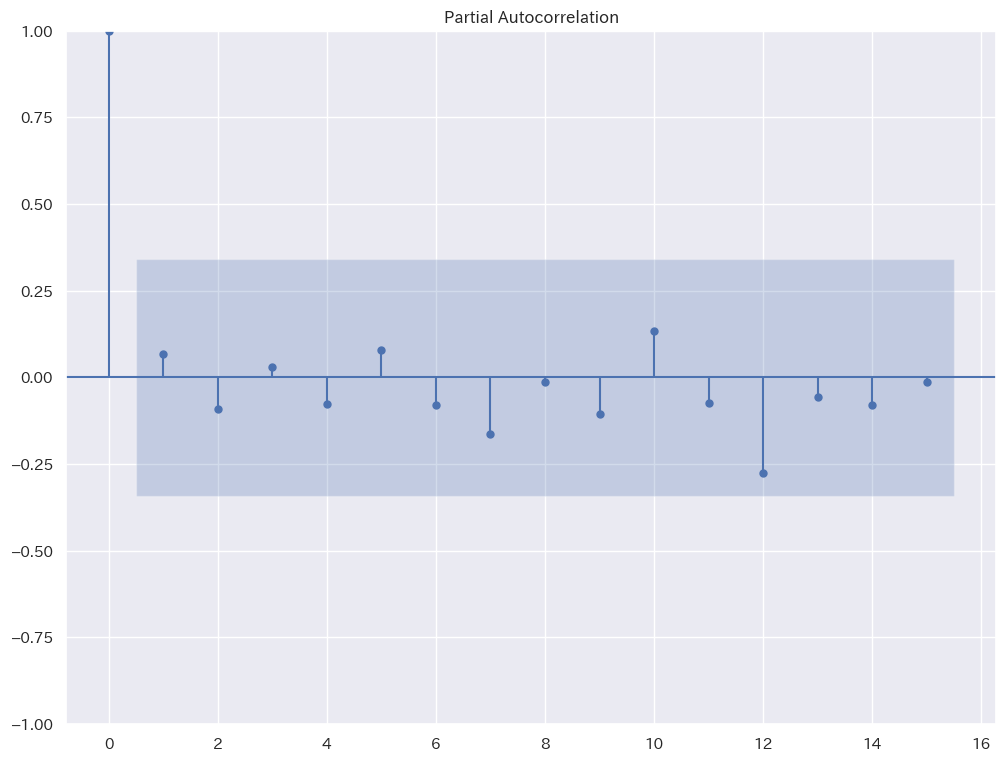

In [37]:
residual = res.resid
plt.bar(range(len(residual)), residual)
plot_pacf(residual, lags=15, method='ywm')
plt.show()

### ARIMAモデル
実務で最も用いられていると思われる時系列数理モデル  
AICが良くなるようにハイパラチューニング

### ホルトウィンターズモデル
指数平滑法にトレンド成分と季節成分を考慮したモデル  
シンプルなため、他モデルに比べて学習が速い

### Prophetモデル
Meta社が開発した一般化加法モデルをベースにした新しめのモデル  
トレンド成分と季節成分をモデル化している点では従来の考え方を踏襲している

### 線形回帰モデル
テーブルデータ用のモデル  
時系列予測をさせるには時系列特徴を作成する必要がある